# Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # process bar
import glob # match required file path (glob.glob)
import matplotlib.pyplot as plt # data visualization/diagram
import torch # pytorch deep learning architect
import torch.nn as nn # Neural Network layer module in pytorch
import torch.optim as optim # optimizer module (argument) in pytorch
import torchvision # load pre-trained model/ 复现论文架构
import torchvision.models as models # load/provide pre-trained model (AlexNet, VGG, ResNet)
import torchvision.transforms as transforms # provide common image pre-process method (flip, center, standardize)
import torchvision.datasets as datasets # define common open-source dataset (CIFAR-10)
from PIL import Image # import image from python imaging library (PIL)
from torch.utils.data import Dataset, DataLoader # dataset -> inheretate and reqrite to create dataset instance of your own
                                                 # dataloader -> iterator, receive dataset and automatically process, shuffle, etc.

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os # python interacts with operating sytem
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# paths

In [2]:
ROOT_PATH = '/kaggle/input/food11-image-dataset' # dataset root category
training_path = f'{ROOT_PATH}/training' # f-string -> insert {content} to string
validation_path = f'{ROOT_PATH}/validation'
evaluation_path = f'{ROOT_PATH}/evaluation'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
batch_size = 32 # 每次输入模型的图片数量 
image_size = 224 # 输入图像的尺寸 （224*224 标准输入尺寸）

#标准化（符合预训练模型的输入要求）
# normalized_image = (original_image - mean) / std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.226]

In [5]:
# 基础预处理 （验证集/测试集）
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)), # 调整图像大小
    transforms.ToTensor(), # 转为张量并归一到 【0，1】
    transforms.Normalize(mean, std) # 标准化
])

# 数据增强处理
aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20), # 随机旋转+/- 20度
    transforms.RandomHorizontalFlip(), # 随机水平翻转（50%）
    transforms.ColorJitter(0.1, 0.1, 0.1), # 随机调整亮度。对比度，饱和度
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing() # 随机擦除部分区域
])

In [6]:
# 调用 Torchvision 中定义的 ResNet-34 模型架构
# 加载在 ImageNet 1K（1000 类）数据集上预训练的权重
model = models.resnet34(weights = 'IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


In [7]:
# 修改预训练 ResNet 模型的最后一层全连接层（fc）使其适应一个新的分类任务
# 获取原全连接层的输入特征维度
in_features = int(model.fc.in_features)

# 替换全连接层（适配 11 类分类任务）
model.fc = nn.Linear(in_features, 11, device)# 不需要手动指定 device

In [8]:
model = model.to(device) # 将整个模型（包括所有参数和缓冲区）移动到指定计算设备（CPU 或 GPU）

In [9]:
#  损失函数 计算多分类任务的交叉熵损失
criterion = nn.CrossEntropyLoss()

# 优化器 使用随机梯度下降（SGD）更新模型参数，带动量（Momentum）加速收敛
# model.parameters()：待优化的模型参数（自动收集所有 requires_grad=True 的参数）。
# lr=0.001：初始学习率（关键超参数，需根据任务调整）。
# momentum=0.9：动量系数（加速收敛并减少震荡，类似“惯性”）
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 学习率调度器
# 作用：每隔 step_size 个 epoch，将学习率乘以 gamma（即衰减为原来的 50%）。
# step_size=5：每 5 个 epoch 调整一次学习率。
# gamma=0.5：学习率衰减因子。
lr_scheduler =optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [10]:
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

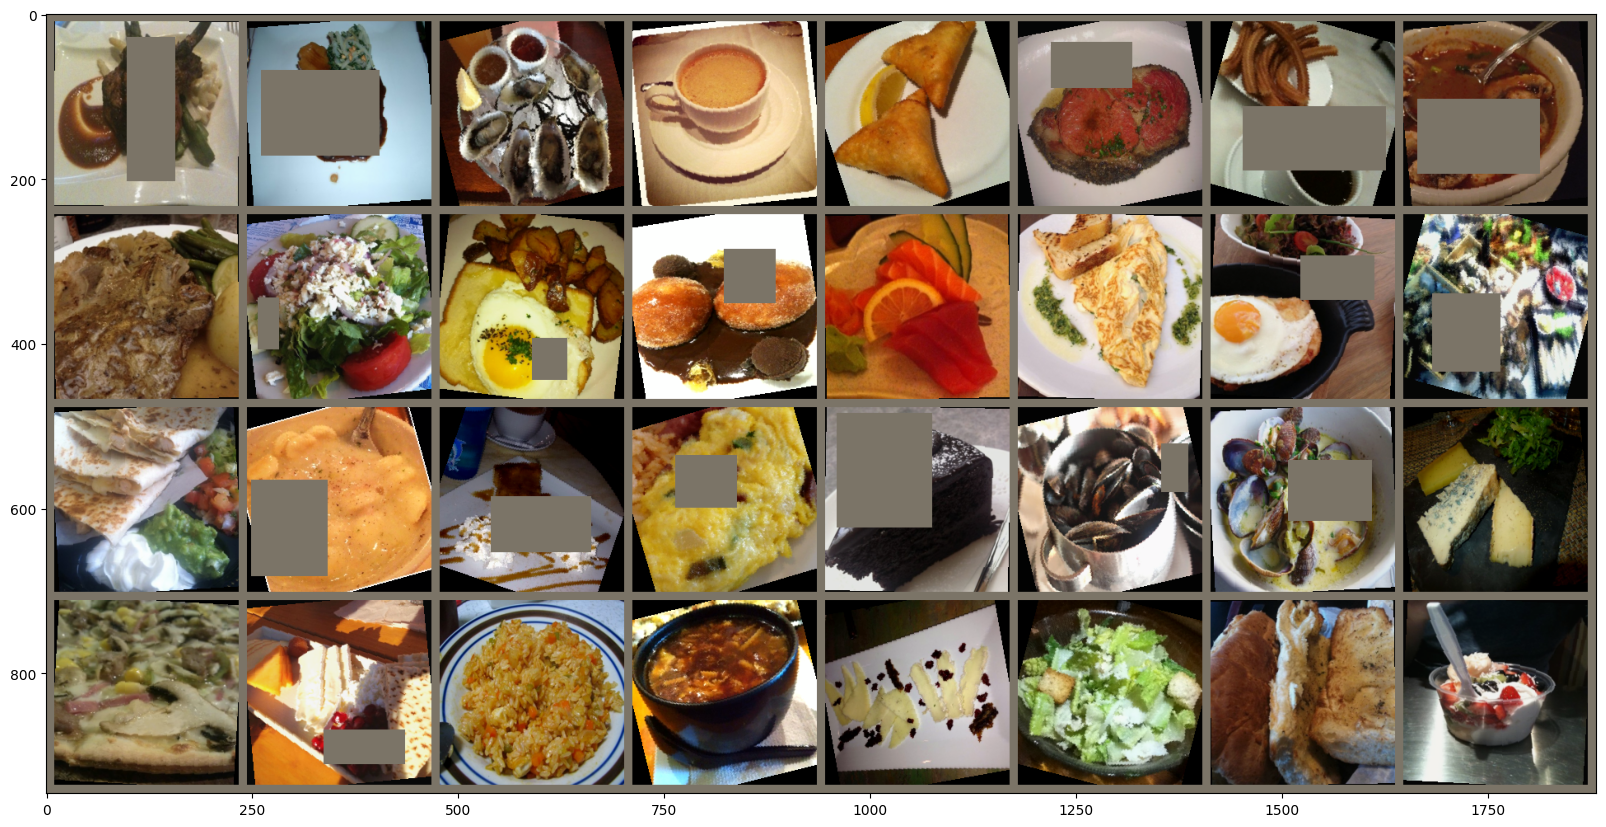

In [12]:
images, targets= next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
    np_image = np.array(images).transpose((1, 2, 0))
    unnorm_image = np_image * std + mean
    plt.figure(figsize=(20, 20))
    plt.imshow(unnorm_image)

imshow(grid_images, mean, std)

In [13]:
num_epochs = 15
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f' % (epoch + 1, num_epochs, i+1, len(train_dataset) // batch_size, loss.item()))

 17%|█▋        | 51/309 [00:11<00:47,  5.38it/s]

Epoch [ 1/15], Step [ 50/308], Loss: 1.4263


 32%|███▏      | 100/309 [00:22<00:57,  3.66it/s]

Epoch [ 1/15], Step [100/308], Loss: 1.2521


 49%|████▉     | 151/309 [00:34<00:31,  5.06it/s]

Epoch [ 1/15], Step [150/308], Loss: 0.7105


 65%|██████▍   | 200/309 [00:44<00:24,  4.44it/s]

Epoch [ 1/15], Step [200/308], Loss: 0.6482


 81%|████████  | 250/309 [00:55<00:16,  3.64it/s]

Epoch [ 1/15], Step [250/308], Loss: 0.5369


 97%|█████████▋| 300/309 [01:06<00:02,  4.06it/s]

Epoch [ 1/15], Step [300/308], Loss: 0.8342


 16%|█▌        | 50/309 [00:08<00:52,  4.96it/s]

Epoch [ 2/15], Step [ 50/308], Loss: 0.6568


 32%|███▏      | 100/309 [00:17<00:46,  4.54it/s]

Epoch [ 2/15], Step [100/308], Loss: 0.2715


 49%|████▊     | 150/309 [00:26<00:33,  4.81it/s]

Epoch [ 2/15], Step [150/308], Loss: 0.3086


 65%|██████▍   | 200/309 [00:35<00:23,  4.68it/s]

Epoch [ 2/15], Step [200/308], Loss: 0.3141


 81%|████████  | 250/309 [00:44<00:13,  4.53it/s]

Epoch [ 2/15], Step [250/308], Loss: 0.4805


 97%|█████████▋| 300/309 [00:54<00:02,  4.39it/s]

Epoch [ 2/15], Step [300/308], Loss: 0.4172


 16%|█▌        | 50/309 [00:10<00:59,  4.35it/s]

Epoch [ 3/15], Step [ 50/308], Loss: 0.4866


 32%|███▏      | 100/309 [00:19<00:46,  4.48it/s]

Epoch [ 3/15], Step [100/308], Loss: 0.1832


 49%|████▊     | 150/309 [00:28<00:34,  4.60it/s]

Epoch [ 3/15], Step [150/308], Loss: 0.3841


 65%|██████▍   | 200/309 [00:38<00:24,  4.50it/s]

Epoch [ 3/15], Step [200/308], Loss: 0.2622


 81%|████████  | 250/309 [00:47<00:12,  4.72it/s]

Epoch [ 3/15], Step [250/308], Loss: 0.7500


 97%|█████████▋| 300/309 [00:56<00:01,  4.63it/s]

Epoch [ 3/15], Step [300/308], Loss: 0.1100


 16%|█▌        | 50/309 [00:10<00:56,  4.62it/s]

Epoch [ 4/15], Step [ 50/308], Loss: 0.2927


 32%|███▏      | 100/309 [00:19<00:45,  4.57it/s]

Epoch [ 4/15], Step [100/308], Loss: 0.1706


 49%|████▊     | 150/309 [00:28<00:35,  4.52it/s]

Epoch [ 4/15], Step [150/308], Loss: 0.3038


 65%|██████▍   | 200/309 [00:37<00:24,  4.52it/s]

Epoch [ 4/15], Step [200/308], Loss: 0.1333


 81%|████████  | 250/309 [00:47<00:13,  4.53it/s]

Epoch [ 4/15], Step [250/308], Loss: 0.3024


 97%|█████████▋| 300/309 [00:56<00:01,  4.57it/s]

Epoch [ 4/15], Step [300/308], Loss: 0.1273


 16%|█▌        | 50/309 [00:09<00:55,  4.63it/s]

Epoch [ 5/15], Step [ 50/308], Loss: 0.4022


 32%|███▏      | 100/309 [00:18<00:45,  4.61it/s]

Epoch [ 5/15], Step [100/308], Loss: 0.2745


 49%|████▊     | 150/309 [00:27<00:34,  4.63it/s]

Epoch [ 5/15], Step [150/308], Loss: 0.2213


 65%|██████▌   | 201/309 [00:37<00:21,  5.13it/s]

Epoch [ 5/15], Step [200/308], Loss: 0.4861


 81%|████████  | 250/309 [00:46<00:12,  4.61it/s]

Epoch [ 5/15], Step [250/308], Loss: 0.2017


 97%|█████████▋| 300/309 [00:55<00:01,  4.63it/s]

Epoch [ 5/15], Step [300/308], Loss: 0.1581


 16%|█▌        | 50/309 [00:09<00:55,  4.66it/s]

Epoch [ 6/15], Step [ 50/308], Loss: 0.3589


 32%|███▏      | 100/309 [00:18<00:45,  4.61it/s]

Epoch [ 6/15], Step [100/308], Loss: 0.1005


 49%|████▊     | 150/309 [00:27<00:34,  4.57it/s]

Epoch [ 6/15], Step [150/308], Loss: 0.1761


 65%|██████▍   | 200/309 [00:37<00:23,  4.57it/s]

Epoch [ 6/15], Step [200/308], Loss: 0.1056


 81%|████████  | 250/309 [00:46<00:12,  4.59it/s]

Epoch [ 6/15], Step [250/308], Loss: 0.3362


 97%|█████████▋| 300/309 [00:55<00:01,  4.55it/s]

Epoch [ 6/15], Step [300/308], Loss: 0.1243


 16%|█▌        | 50/309 [00:09<00:56,  4.60it/s]

Epoch [ 7/15], Step [ 50/308], Loss: 0.1680


 32%|███▏      | 100/309 [00:18<00:45,  4.55it/s]

Epoch [ 7/15], Step [100/308], Loss: 0.2429


 49%|████▊     | 150/309 [00:28<00:34,  4.59it/s]

Epoch [ 7/15], Step [150/308], Loss: 0.1043


 65%|██████▍   | 200/309 [00:37<00:23,  4.56it/s]

Epoch [ 7/15], Step [200/308], Loss: 0.2113


 81%|████████  | 250/309 [00:46<00:13,  4.53it/s]

Epoch [ 7/15], Step [250/308], Loss: 0.2919


 97%|█████████▋| 300/309 [00:55<00:01,  4.52it/s]

Epoch [ 7/15], Step [300/308], Loss: 0.2037


 16%|█▌        | 50/309 [00:09<00:56,  4.57it/s]

Epoch [ 8/15], Step [ 50/308], Loss: 0.3020


 32%|███▏      | 100/309 [00:18<00:46,  4.54it/s]

Epoch [ 8/15], Step [100/308], Loss: 0.1256


 49%|████▊     | 150/309 [00:28<00:34,  4.57it/s]

Epoch [ 8/15], Step [150/308], Loss: 0.0855


 65%|██████▍   | 200/309 [00:37<00:23,  4.55it/s]

Epoch [ 8/15], Step [200/308], Loss: 0.1293


 81%|████████  | 250/309 [00:46<00:12,  4.58it/s]

Epoch [ 8/15], Step [250/308], Loss: 0.0409


 97%|█████████▋| 300/309 [00:55<00:01,  4.59it/s]

Epoch [ 8/15], Step [300/308], Loss: 0.3226


 16%|█▌        | 50/309 [00:09<00:56,  4.56it/s]

Epoch [ 9/15], Step [ 50/308], Loss: 0.3646


 32%|███▏      | 100/309 [00:19<00:45,  4.55it/s]

Epoch [ 9/15], Step [100/308], Loss: 0.2469


 49%|████▊     | 150/309 [00:28<00:34,  4.56it/s]

Epoch [ 9/15], Step [150/308], Loss: 0.0858


 65%|██████▍   | 200/309 [00:37<00:23,  4.56it/s]

Epoch [ 9/15], Step [200/308], Loss: 0.2478


 81%|████████  | 250/309 [00:47<00:12,  4.61it/s]

Epoch [ 9/15], Step [250/308], Loss: 0.0906


 97%|█████████▋| 300/309 [00:56<00:01,  4.54it/s]

Epoch [ 9/15], Step [300/308], Loss: 0.1824


 16%|█▌        | 50/309 [00:09<00:56,  4.58it/s]

Epoch [10/15], Step [ 50/308], Loss: 0.1857


 32%|███▏      | 100/309 [00:18<00:45,  4.60it/s]

Epoch [10/15], Step [100/308], Loss: 0.1796


 49%|████▊     | 150/309 [00:27<00:34,  4.56it/s]

Epoch [10/15], Step [150/308], Loss: 0.0564


 65%|██████▍   | 200/309 [00:37<00:23,  4.59it/s]

Epoch [10/15], Step [200/308], Loss: 0.1205


 81%|████████  | 250/309 [00:46<00:12,  4.60it/s]

Epoch [10/15], Step [250/308], Loss: 0.2749


 97%|█████████▋| 300/309 [00:56<00:01,  4.56it/s]

Epoch [10/15], Step [300/308], Loss: 0.3838


 16%|█▌        | 50/309 [00:09<00:56,  4.55it/s]

Epoch [11/15], Step [ 50/308], Loss: 0.1859


 32%|███▏      | 100/309 [00:18<00:45,  4.59it/s]

Epoch [11/15], Step [100/308], Loss: 0.0515


 49%|████▊     | 150/309 [00:28<00:34,  4.59it/s]

Epoch [11/15], Step [150/308], Loss: 0.1058


 65%|██████▍   | 200/309 [00:37<00:23,  4.59it/s]

Epoch [11/15], Step [200/308], Loss: 0.2285


 81%|████████  | 250/309 [00:46<00:13,  4.39it/s]

Epoch [11/15], Step [250/308], Loss: 0.3040


 97%|█████████▋| 300/309 [00:55<00:01,  4.60it/s]

Epoch [11/15], Step [300/308], Loss: 0.1345


 16%|█▌        | 50/309 [00:09<00:56,  4.59it/s]

Epoch [12/15], Step [ 50/308], Loss: 0.1310


 32%|███▏      | 100/309 [00:18<00:45,  4.56it/s]

Epoch [12/15], Step [100/308], Loss: 0.1189


 49%|████▊     | 150/309 [00:28<00:34,  4.57it/s]

Epoch [12/15], Step [150/308], Loss: 0.3182


 65%|██████▍   | 200/309 [00:37<00:23,  4.59it/s]

Epoch [12/15], Step [200/308], Loss: 0.3172


 81%|████████  | 250/309 [00:46<00:12,  4.57it/s]

Epoch [12/15], Step [250/308], Loss: 0.1620


 97%|█████████▋| 300/309 [00:56<00:01,  4.56it/s]

Epoch [12/15], Step [300/308], Loss: 0.1290


 16%|█▌        | 50/309 [00:09<00:56,  4.58it/s]

Epoch [13/15], Step [ 50/308], Loss: 0.0718


 32%|███▏      | 100/309 [00:18<00:45,  4.60it/s]

Epoch [13/15], Step [100/308], Loss: 0.0716


 49%|████▊     | 150/309 [00:28<00:36,  4.38it/s]

Epoch [13/15], Step [150/308], Loss: 0.1265


 65%|██████▍   | 200/309 [00:37<00:23,  4.57it/s]

Epoch [13/15], Step [200/308], Loss: 0.1492


 81%|████████  | 250/309 [00:47<00:12,  4.58it/s]

Epoch [13/15], Step [250/308], Loss: 0.0968


 97%|█████████▋| 300/309 [00:56<00:01,  4.62it/s]

Epoch [13/15], Step [300/308], Loss: 0.0856


 16%|█▌        | 50/309 [00:09<00:56,  4.59it/s]

Epoch [14/15], Step [ 50/308], Loss: 0.1131


 32%|███▏      | 100/309 [00:18<00:45,  4.58it/s]

Epoch [14/15], Step [100/308], Loss: 0.0271


 49%|████▊     | 150/309 [00:28<00:34,  4.56it/s]

Epoch [14/15], Step [150/308], Loss: 0.0127


 65%|██████▍   | 200/309 [00:37<00:23,  4.56it/s]

Epoch [14/15], Step [200/308], Loss: 0.0279


 81%|████████  | 250/309 [00:47<00:13,  4.33it/s]

Epoch [14/15], Step [250/308], Loss: 0.1481


 97%|█████████▋| 300/309 [00:56<00:01,  4.55it/s]

Epoch [14/15], Step [300/308], Loss: 0.0200


 16%|█▌        | 50/309 [00:10<00:56,  4.57it/s]

Epoch [15/15], Step [ 50/308], Loss: 0.0103


 32%|███▏      | 100/309 [00:19<00:45,  4.56it/s]

Epoch [15/15], Step [100/308], Loss: 0.1825


 49%|████▊     | 150/309 [00:28<00:35,  4.53it/s]

Epoch [15/15], Step [150/308], Loss: 0.0717


 65%|██████▍   | 200/309 [00:38<00:24,  4.53it/s]

Epoch [15/15], Step [200/308], Loss: 0.1243


 81%|████████  | 250/309 [00:47<00:13,  4.53it/s]

Epoch [15/15], Step [250/308], Loss: 0.0534


 97%|█████████▋| 300/309 [00:56<00:01,  4.53it/s]

Epoch [15/15], Step [300/308], Loss: 0.0652


100%|██████████| 309/309 [00:58<00:00,  5.30it/s]


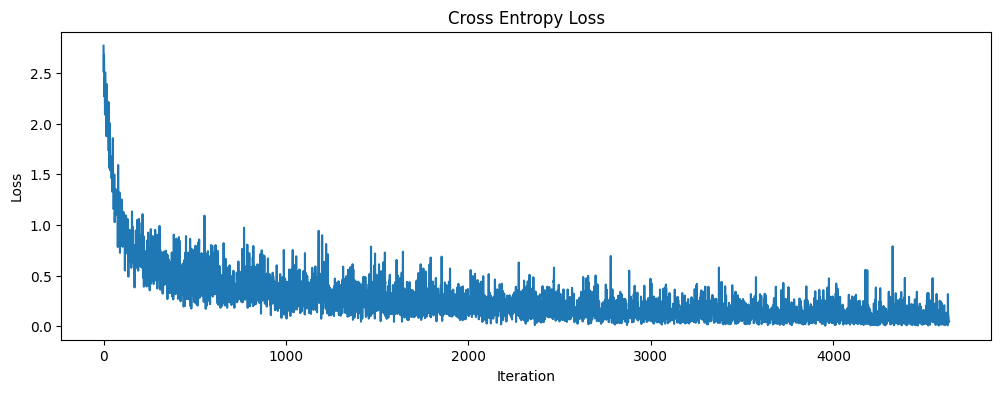

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss')
plt.show()

In [15]:
def evaluate_model(model, dataloader, device):
    model.eval()
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    print(f'accuracy: {100.0 * corrects / len(dataloader.dataset)}')

In [16]:
evaluate_model(model, evaluation_dataloader, device)

accuracy: 92.91903686523438
